<!--- Licensed to the Apache Software Foundation (ASF) under one -->
<!--- or more contributor license agreements.  See the NOTICE file -->
<!--- distributed with this work for additional information -->
<!--- regarding copyright ownership.  The ASF licenses this file -->
<!--- to you under the Apache License, Version 2.0 (the -->
<!--- "License"); you may not use this file except in compliance -->
<!--- with the License.  You may obtain a copy of the License at -->

<!---   http://www.apache.org/licenses/LICENSE-2.0 -->

<!--- Unless required by applicable law or agreed to in writing, -->
<!--- software distributed under the License is distributed on an -->
<!--- "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY -->
<!--- KIND, either express or implied.  See the License for the -->
<!--- specific language governing permissions and limitations -->
<!--- under the License. -->

# Step 6: Train a Neural Network

Now that you have seen all the necessary components for creating a neural network, you are
now ready to put all the pieces together and train a model end to end.

## 1. Data preparation

The typical process for creating and training a model starts with loading and
preparing the datasets. For this Network you will use a [dataset of leaf
images](https://data.mendeley.com/datasets/hb74ynkjcn/1) that consists of healthy
and diseased examples of leafs from twelve different plant species. To get this
dataset you have to download and extract it with the following commands.

In [1]:
# Import all the necessary libraries to train
import time
import os
import zipfile

import mxnet as mx
from mxnet import np, npx, gluon, init, autograd
from mxnet.gluon import nn
from mxnet.gluon.data.vision import transforms

import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import numpy as np

from prepare_dataset import process_dataset #utility code to rearrange the data

mx.np.random.seed(42)

In [2]:
# Download dataset
url = 'https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/hb74ynkjcn-1.zip'
zip_file_path = mx.gluon.utils.download(url)

os.makedirs('plants', exist_ok=True)

with zipfile.ZipFile(zip_file_path, 'r') as zf:
    zf.extractall('plants')

os.remove(zip_file_path)

#### Data inspection

If you take a look at the dataset you find the following structure for the directories:

```
plants
|-- Alstonia Scholaris (P2)
|-- Arjun (P1)
|-- Bael (P4)
    |-- diseased
        |-- 0016_0001.JPG
        |-- .
        |-- .
        |-- .
        |-- 0016_0118.JPG
|-- .
|-- .
|-- .
|-- Mango (P0)
    |-- diseased
    |-- healthy
```


Each plant species has its own directory, for each of those directories you might
find subdirectories with examples of diseased leaves, healthy
leaves, or both. With this dataset you can formulate different classification
problems; for example, you can create a multi-class classifier that determines
the species of a plant based on the leaves; you can instead create a binary
classifier that tells you whether the plant is healthy or diseased. Additionally, you can create
a multi-class, multi-label classifier that tells you both: what species a
plant is and whether the plant is diseased or healthy. In this example you will stick to
the simplest classification question, which is whether a plant is healthy or not.

To do this, you need to manipulate the dataset in two ways. First, you need to
combine all images with labels consisting of healthy and diseased, regardless of the species, and then you
need to split the data into train, validation, and test sets. We prepared a
small utility script that does this to get the dataset ready for you.
Once you run this utility code on the data, the structure will be
already organized in folders containing the right images in each of the classes,
you can use the `ImageFolderDataset` class to import the images from the file to MXNet.

In [3]:
# Call the utility function to rearrange the images
process_dataset('plants')

The dataset is located in the `datasets` folder and the new structure
looks like this:

```
datasets
|-- test
    |-- diseased
    |-- healthy
|-- train
|-- validation
    |-- diseased
    |-- healthy
        |-- image1.JPG
        |-- image2.JPG
        |-- .
        |-- .
        |-- .
        |-- imagen.JPG
```


Now, you need to create three different Dataset objects from the `train`,
`validation`, and `test` folders, and the `ImageFolderDataset` class takes
care of inferring the classes from the directory names. If you don't remember
how the `ImageFolderDataset` works, take a look at [Step 5](5-datasets.md)
of this course for a deeper description.

In [4]:
# Use ImageFolderDataset to create a Dataset object from directory structure
train_dataset = gluon.data.vision.ImageFolderDataset('./datasets/train')
val_dataset = gluon.data.vision.ImageFolderDataset('./datasets/validation')
test_dataset = gluon.data.vision.ImageFolderDataset('./datasets/test')

The result from this operation is a different Dataset object for each folder.
These objects hold a collection of images and labels and as such they can be
indexed, to get the $i$-th element from the dataset. The $i$-th element is a
tuple with two objects, the first object of the tuple is the image in array
form and the second is the corresponding label for that image.

[15:08:27] /work/mxnet/src/storage/storage.cc:199: Using Pooled (Naive) StorageManager for CPU


Data type: uint8
Label: 0
Label description: diseased
Image shape: (4000, 6000, 3)


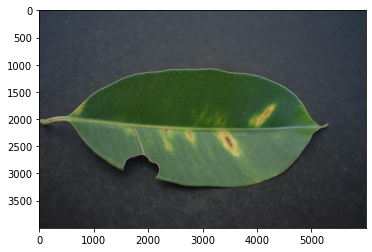

In [5]:
sample_idx = 888 # choose a random sample
sample = train_dataset[sample_idx]
data = sample[0]
label = sample[1]

plt.imshow(data.asnumpy())
print(f"Data type: {data.dtype}")
print(f"Label: {label}")
print(f"Label description: {train_dataset.synsets[label]}")
print(f"Image shape: {data.shape}")

As you can see from the plot, the image size is very large 4000 x 6000 pixels.
Usually, you downsize images before passing them to a neural network to reduce the training time.
It is also customary to make slight modifications to the images to improve generalization. That is why you add
transformations to the data in a process called Data Augmentation.

You can augment data in MXNet using `transforms`. For a complete list of all
the available transformations in MXNet check out
[available transforms](../../../api/gluon/data/vision/transforms/index.rst).
It is very common to use more than one transform per image, and it is also
common to process transforms sequentially. To this end, you can use the `transforms.Compose` class.
This class is very useful to create a transformation pipeline for your images.

You have to compose two different transformation pipelines, one for training
and the other one for validating and testing. This is because each pipeline
serves different pursposes. You need to downsize, convert to tensor and normalize
images across all the different datsets; however, you typically do not want to randomly flip
or add color jitter to the validation or test images since you could reduce performance.

In [6]:
# Import transforms as compose a series of transformations to the images
from mxnet.gluon.data.vision import transforms

jitter_param = 0.05

# mean and std for normalizing image value in range (0,1)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

training_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.RandomFlipLeftRight(),
    transforms.RandomColorJitter(contrast=jitter_param),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

validation_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

With your augmentations ready, you can create the `DataLoaders` to use them. To
do this the `gluon.data.DataLoader` class comes in handy. You have to pass the dataset with
the applied transformations (notice the `.transform_first()` method on the datasets)
to `gluon.data.DataLoader`. Additionally, you need to decide the batch size,
which is how many images you will be passing to the network,
and whether you want to shuffle the dataset.

In [7]:
# Create data loaders
batch_size = 4
train_loader = gluon.data.DataLoader(train_dataset.transform_first(training_transformer),
                                     batch_size=batch_size,
                                     shuffle=True,
                                     try_nopython=True)
validation_loader = gluon.data.DataLoader(val_dataset.transform_first(validation_transformer),
                                          batch_size=batch_size,
                                          try_nopython=True)
test_loader = gluon.data.DataLoader(test_dataset.transform_first(validation_transformer),
                                    batch_size=batch_size,
                                    try_nopython=True)

Now, you can inspect the transformations that you made to the images. A prepared
utility function has been provided for this.

In [8]:
# Function to plot batch
def show_batch(batch, columns=4, fig_size=(9, 5), pad=1):
    labels = batch[1].asnumpy()
    batch = batch[0] / 2 + 0.5     # unnormalize
    batch = np.clip(batch.asnumpy(), 0, 1) # clip values
    size = batch.shape[0]
    rows = int(size / columns)
    fig, axes = plt.subplots(rows, columns, figsize=fig_size)
    for ax, img, label in zip(axes.flatten(), batch, labels):
        ax.imshow(np.transpose(img, (1, 2, 0)))
        ax.set(title=f"Label: {label}")
    fig.tight_layout(h_pad=pad, w_pad=pad)
    plt.show()

In [9]:
for batch in train_loader:
    a = batch
    break

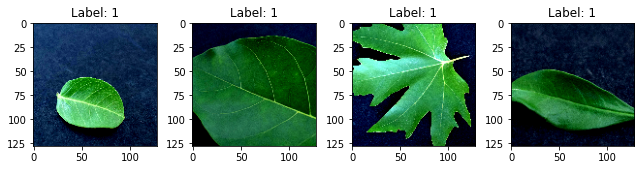

In [10]:
show_batch(a)

You can see that the original images changed to have different sizes and variations
in color and lighting. These changes followed the specified transformations you stated
in the pipeline. You are now ready to go to the next step: **Create the
architecture**.

## 2. Create Neural Network

Convolutional neural networks are a great tool to capture the spatial
relationship of pixel values within images, for this reason they have become the
gold standard for computer vision. In this example you will create a small convolutional neural
network using what you learned from [Step 2](2-create-nn.md) of this crash course series.
First, you can set up two functions that will generate the two types of blocks
you intend to use, the convolution block and the dense block. Then you can create an
entire network based on these two blocks using a custom class.

In [11]:
# The convolutional block has a convolution layer, a max pool layer and a batch normalization layer
def conv_block(filters, kernel_size=2, stride=2, batch_norm=True):
    conv_block = nn.HybridSequential()
    conv_block.add(nn.Conv2D(channels=filters, kernel_size=kernel_size, activation='relu'),
              nn.MaxPool2D(pool_size=4, strides=stride))
    if batch_norm:
        conv_block.add(nn.BatchNorm())
    return conv_block

# The dense block consists of a dense layer and a dropout layer
def dense_block(neurons, activation='relu', dropout=0.2):
    dense_block = nn.HybridSequential()
    dense_block.add(nn.Dense(neurons, activation=activation))
    if dropout:
        dense_block.add(nn.Dropout(dropout))
    return dense_block

In [12]:
# Create neural network blueprint using the blocks
class LeafNetwork(nn.HybridBlock):
    def __init__(self):
        super(LeafNetwork, self).__init__()
        self.conv1 = conv_block(32)
        self.conv2 = conv_block(64)
        self.conv3 = conv_block(128)
        self.flatten = nn.Flatten()
        self.dense1 = dense_block(100)
        self.dense2 = dense_block(10)
        self.dense3 = nn.Dense(2)

    def forward(self, batch):
        batch = self.conv1(batch)
        batch = self.conv2(batch)
        batch = self.conv3(batch)
        batch = self.flatten(batch)
        batch = self.dense1(batch)
        batch = self.dense2(batch)
        batch = self.dense3(batch)

        return batch

You have concluded the architecting part of the network, so now you can actually
build a model from that architecture for training. As you have seen
previously on [Step 4](4-components.md) of this
crash course series, to use the network you need to initialize the parameters and
hybridize the model.

In [13]:
# Create the model based on the blueprint provided and initialize the parameters
ctx = mx.gpu()

initializer = mx.initializer.Xavier()

model = LeafNetwork()
model.initialize(initializer, ctx=ctx)
model.summary(mx.np.random.uniform(size=(4, 3, 128, 128), ctx=ctx))
model.hybridize()

[15:08:33] /work/mxnet/src/storage/storage.cc:199: Using Pooled (Naive) StorageManager for GPU


--------------------------------------------------------------------------------
        Layer (type)                                Output Shape         Param #
               Input                            (4, 3, 128, 128)               0
        Activation-1                           (4, 32, 127, 127)               0
            Conv2D-2                           (4, 32, 127, 127)             416
         MaxPool2D-3                             (4, 32, 62, 62)               0
         BatchNorm-4                             (4, 32, 62, 62)             128
        Activation-5                             (4, 64, 61, 61)               0
            Conv2D-6                             (4, 64, 61, 61)            8256
         MaxPool2D-7                             (4, 64, 29, 29)               0
         BatchNorm-8                             (4, 64, 29, 29)             256
        Activation-9                            (4, 128, 28, 28)               0
           Conv2D-10        

[15:08:35] /work/mxnet/src/operator/nn/./cudnn/./cudnn_algoreg-inl.h:97: Running performance tests to find the best convolution algorithm, this can take a while... (set the environment variable MXNET_CUDNN_AUTOTUNE_DEFAULT to 0 to disable)


## 3. Choose Optimizer and Loss function

With the network created you can move on to choosing an optimizer and a loss
function. The network you created uses these components to make an informed decision on how
to tune the parameters to fit the final objective better. You can use the `gluon.Trainer` class to
help with optimizing these parameters. The `gluon.Trainer` class needs two things to work
properly: the parameters needing to be tuned and the optimizer with its
corresponding hyperparameters. The trainer uses the error reported by the loss
function to optimize these parameters.

For this particular dataset you will use Stochastic Gradient Descent as the
optimizer and Cross Entropy as the loss function.

In [14]:
# SGD optimizer
optimizer = 'sgd'

# Set parameters
optimizer_params = {'learning_rate': 0.001}

# Define the trainer for the model
trainer = gluon.Trainer(model.collect_params(), optimizer, optimizer_params)

# Define the loss function
loss_fn = gluon.loss.SoftmaxCrossEntropyLoss()

Finally, you have to set up the training loop, and you need to create a function to evaluate the performance of the network on the validation dataset.

In [15]:
# Function to return the accuracy for the validation and test set
def test(val_data):
    acc = gluon.metric.Accuracy()
    for batch in val_data:
        data = batch[0]
        labels = batch[1]
        outputs = model(data.as_in_ctx(ctx))
        acc.update([labels], [outputs])

    _, accuracy = acc.get()
    return accuracy

## 4. Training Loop

Now that you have everything set up, you can start training your network. This might
take some time to train depending on the hardware, number of layers, batch size and
images you use. For this particular case, you will only train for 2 epochs.

In [16]:
# Start the training loop
epochs = 2
accuracy = gluon.metric.Accuracy()
log_interval = 5

for epoch in range(epochs):
    tic = time.time()
    btic = time.time()
    accuracy.reset()

    for idx, batch in enumerate(train_loader):
        data = batch[0]
        label = batch[1]
        with mx.autograd.record():
            outputs = model(data.as_in_ctx(ctx))
            loss = loss_fn(outputs, label.as_in_ctx(ctx))
        mx.autograd.backward(loss)
        trainer.step(batch_size)
        accuracy.update([label], [outputs])
        if log_interval and (idx + 1) % log_interval == 0:
            _, acc = accuracy.get()

            print(f"""Epoch[{epoch + 1}] Batch[{idx + 1}] Speed: {batch_size / (time.time() - btic)} samples/sec \
                  batch loss = {loss.mean().item()} | accuracy = {acc}""")
            btic = time.time()

    _, acc = accuracy.get()

    acc_val = test(validation_loader)
    print(f"[Epoch {epoch + 1}] training: accuracy={acc}")
    print(f"[Epoch {epoch + 1}] time cost: {time.time() - tic}")
    print(f"[Epoch {epoch + 1}] validation: validation accuracy={acc_val}")

Epoch[1] Batch[5] Speed: 1.24700959769537 samples/sec                   batch loss = 0.8584831357002258 | accuracy = 0.5


Epoch[1] Batch[10] Speed: 1.2444639609301056 samples/sec                   batch loss = 0.5375499129295349 | accuracy = 0.625


Epoch[1] Batch[15] Speed: 1.2684429932298662 samples/sec                   batch loss = 1.357882022857666 | accuracy = 0.6166666666666667


Epoch[1] Batch[20] Speed: 1.2581553506760108 samples/sec                   batch loss = 0.5121141672134399 | accuracy = 0.6


Epoch[1] Batch[25] Speed: 1.1913044768741006 samples/sec                   batch loss = 0.24516941606998444 | accuracy = 0.61


Epoch[1] Batch[30] Speed: 1.2637175082014036 samples/sec                   batch loss = 0.8272877931594849 | accuracy = 0.625


Epoch[1] Batch[35] Speed: 1.2529231447555307 samples/sec                   batch loss = 0.3070518672466278 | accuracy = 0.6071428571428571


Epoch[1] Batch[40] Speed: 1.2619441813704175 samples/sec                   batch loss = 0.7093782424926758 | accuracy = 0.60625


Epoch[1] Batch[45] Speed: 1.2640950395551094 samples/sec                   batch loss = 0.4095161557197571 | accuracy = 0.5944444444444444


Epoch[1] Batch[50] Speed: 1.2710002492422354 samples/sec                   batch loss = 2.849058151245117 | accuracy = 0.595


Epoch[1] Batch[55] Speed: 1.265408012840215 samples/sec                   batch loss = 0.5597673058509827 | accuracy = 0.5909090909090909


Epoch[1] Batch[60] Speed: 1.2611349331607842 samples/sec                   batch loss = 0.6411507725715637 | accuracy = 0.5666666666666667


Epoch[1] Batch[65] Speed: 1.2602689716038622 samples/sec                   batch loss = 0.4639403522014618 | accuracy = 0.5576923076923077


Epoch[1] Batch[70] Speed: 1.271862513561267 samples/sec                   batch loss = 0.33018195629119873 | accuracy = 0.5607142857142857


Epoch[1] Batch[75] Speed: 1.2688441770202776 samples/sec                   batch loss = 0.6944514513015747 | accuracy = 0.5666666666666667


Epoch[1] Batch[80] Speed: 1.267063045789424 samples/sec                   batch loss = 0.7822312116622925 | accuracy = 0.58125


Epoch[1] Batch[85] Speed: 1.2625999485845396 samples/sec                   batch loss = 0.5378276705741882 | accuracy = 0.5794117647058824


Epoch[1] Batch[90] Speed: 1.269829601915021 samples/sec                   batch loss = 0.7852252721786499 | accuracy = 0.5861111111111111


Epoch[1] Batch[95] Speed: 1.2635068932801157 samples/sec                   batch loss = 0.8007204532623291 | accuracy = 0.5763157894736842


Epoch[1] Batch[100] Speed: 1.2715762150323886 samples/sec                   batch loss = 0.2246008813381195 | accuracy = 0.5875


Epoch[1] Batch[105] Speed: 1.266851027350325 samples/sec                   batch loss = 0.2998150587081909 | accuracy = 0.5976190476190476


Epoch[1] Batch[110] Speed: 1.2691611207932014 samples/sec                   batch loss = 0.6280544996261597 | accuracy = 0.6022727272727273


Epoch[1] Batch[115] Speed: 1.2651346294945935 samples/sec                   batch loss = 0.7694488167762756 | accuracy = 0.5978260869565217


Epoch[1] Batch[120] Speed: 1.2699507127399692 samples/sec                   batch loss = 0.6251588463783264 | accuracy = 0.5979166666666667


Epoch[1] Batch[125] Speed: 1.2700150262107075 samples/sec                   batch loss = 0.6391736268997192 | accuracy = 0.604


Epoch[1] Batch[130] Speed: 1.2734998767657846 samples/sec                   batch loss = 1.1552085876464844 | accuracy = 0.6


Epoch[1] Batch[135] Speed: 1.2590617772842423 samples/sec                   batch loss = 1.1165800094604492 | accuracy = 0.5981481481481481


Epoch[1] Batch[140] Speed: 1.265846436100024 samples/sec                   batch loss = 0.9502311944961548 | accuracy = 0.6


Epoch[1] Batch[145] Speed: 1.2618909331705088 samples/sec                   batch loss = 0.34051328897476196 | accuracy = 0.6051724137931035


Epoch[1] Batch[150] Speed: 1.2592169448174062 samples/sec                   batch loss = 0.5836989879608154 | accuracy = 0.6066666666666667


Epoch[1] Batch[155] Speed: 1.2639210519436463 samples/sec                   batch loss = 0.7103639841079712 | accuracy = 0.6096774193548387


Epoch[1] Batch[160] Speed: 1.2654334010228783 samples/sec                   batch loss = 0.5314779281616211 | accuracy = 0.6078125


Epoch[1] Batch[165] Speed: 1.2674558883510918 samples/sec                   batch loss = 0.6654741764068604 | accuracy = 0.6121212121212121


Epoch[1] Batch[170] Speed: 1.2627708163323983 samples/sec                   batch loss = 0.6995912194252014 | accuracy = 0.611764705882353


Epoch[1] Batch[175] Speed: 1.2666397492512902 samples/sec                   batch loss = 0.4223766028881073 | accuracy = 0.6157142857142858


Epoch[1] Batch[180] Speed: 1.2604932817632404 samples/sec                   batch loss = 0.6514976024627686 | accuracy = 0.6152777777777778


Epoch[1] Batch[185] Speed: 1.2669060343429286 samples/sec                   batch loss = 0.34739816188812256 | accuracy = 0.6162162162162163


Epoch[1] Batch[190] Speed: 1.2636102409482475 samples/sec                   batch loss = 0.692161500453949 | accuracy = 0.6197368421052631


Epoch[1] Batch[195] Speed: 1.2688272880343798 samples/sec                   batch loss = 0.4469107389450073 | accuracy = 0.6243589743589744


Epoch[1] Batch[200] Speed: 1.2634955698395585 samples/sec                   batch loss = 0.5889226198196411 | accuracy = 0.6225


Epoch[1] Batch[205] Speed: 1.261588898762197 samples/sec                   batch loss = 1.282776117324829 | accuracy = 0.6182926829268293


Epoch[1] Batch[210] Speed: 1.2640341812984568 samples/sec                   batch loss = 0.4783158302307129 | accuracy = 0.6190476190476191


Epoch[1] Batch[215] Speed: 1.2619738922122539 samples/sec                   batch loss = 0.602195680141449 | accuracy = 0.622093023255814


Epoch[1] Batch[220] Speed: 1.268338853564049 samples/sec                   batch loss = 0.5768325924873352 | accuracy = 0.6204545454545455


Epoch[1] Batch[225] Speed: 1.2646531324316825 samples/sec                   batch loss = 0.46841105818748474 | accuracy = 0.6244444444444445


Epoch[1] Batch[230] Speed: 1.2669349268854222 samples/sec                   batch loss = 0.39118629693984985 | accuracy = 0.6293478260869565


Epoch[1] Batch[235] Speed: 1.2703618928746692 samples/sec                   batch loss = 0.5152057409286499 | accuracy = 0.6276595744680851


Epoch[1] Batch[240] Speed: 1.2730406811579127 samples/sec                   batch loss = 0.7737094163894653 | accuracy = 0.63125


Epoch[1] Batch[245] Speed: 1.2679251488661145 samples/sec                   batch loss = 1.7516814470291138 | accuracy = 0.6326530612244898


Epoch[1] Batch[250] Speed: 1.2680803044200084 samples/sec                   batch loss = 0.6595956683158875 | accuracy = 0.631


Epoch[1] Batch[255] Speed: 1.2627999958150578 samples/sec                   batch loss = 0.298959344625473 | accuracy = 0.6313725490196078


Epoch[1] Batch[260] Speed: 1.2651559043078768 samples/sec                   batch loss = 0.29278576374053955 | accuracy = 0.6346153846153846


Epoch[1] Batch[265] Speed: 1.263916862356427 samples/sec                   batch loss = 0.5268943905830383 | accuracy = 0.6358490566037736


Epoch[1] Batch[270] Speed: 1.2646635233281698 samples/sec                   batch loss = 0.49873360991477966 | accuracy = 0.6370370370370371


Epoch[1] Batch[275] Speed: 1.2610219430176046 samples/sec                   batch loss = 0.40674352645874023 | accuracy = 0.6381818181818182


Epoch[1] Batch[280] Speed: 1.2656850472669983 samples/sec                   batch loss = 0.5460024476051331 | accuracy = 0.6366071428571428


Epoch[1] Batch[285] Speed: 1.2662559180682513 samples/sec                   batch loss = 0.45368772745132446 | accuracy = 0.6385964912280702


Epoch[1] Batch[290] Speed: 1.268548972414462 samples/sec                   batch loss = 0.6687886118888855 | accuracy = 0.6396551724137931


Epoch[1] Batch[295] Speed: 1.2639347635141982 samples/sec                   batch loss = 1.4623746871948242 | accuracy = 0.6398305084745762


Epoch[1] Batch[300] Speed: 1.2625409443823146 samples/sec                   batch loss = 0.5823876261711121 | accuracy = 0.6408333333333334


Epoch[1] Batch[305] Speed: 1.2686055658379058 samples/sec                   batch loss = 0.46236658096313477 | accuracy = 0.6385245901639345


Epoch[1] Batch[310] Speed: 1.268548588747468 samples/sec                   batch loss = 0.6822093725204468 | accuracy = 0.6403225806451613


Epoch[1] Batch[315] Speed: 1.2607294191784557 samples/sec                   batch loss = 0.6603452563285828 | accuracy = 0.6396825396825396


Epoch[1] Batch[320] Speed: 1.267774054847203 samples/sec                   batch loss = 0.510750949382782 | accuracy = 0.6375


Epoch[1] Batch[325] Speed: 1.2653653515342875 samples/sec                   batch loss = 0.6710084080696106 | accuracy = 0.6369230769230769


Epoch[1] Batch[330] Speed: 1.261308913107332 samples/sec                   batch loss = 0.8906174898147583 | accuracy = 0.6386363636363637


Epoch[1] Batch[335] Speed: 1.268078099967741 samples/sec                   batch loss = 0.9810564517974854 | accuracy = 0.6402985074626866


Epoch[1] Batch[340] Speed: 1.2632677168437343 samples/sec                   batch loss = 0.6274642944335938 | accuracy = 0.6411764705882353


Epoch[1] Batch[345] Speed: 1.2719531534244455 samples/sec                   batch loss = 0.7078320384025574 | accuracy = 0.6405797101449275


Epoch[1] Batch[350] Speed: 1.2670806533994852 samples/sec                   batch loss = 1.8407801389694214 | accuracy = 0.6428571428571429


Epoch[1] Batch[355] Speed: 1.2699137042036124 samples/sec                   batch loss = 0.888871431350708 | accuracy = 0.6429577464788733


Epoch[1] Batch[360] Speed: 1.268430909850252 samples/sec                   batch loss = 0.3791607916355133 | accuracy = 0.6451388888888889


Epoch[1] Batch[365] Speed: 1.271060720873144 samples/sec                   batch loss = 0.5033864378929138 | accuracy = 0.6465753424657534


Epoch[1] Batch[370] Speed: 1.2611488687504233 samples/sec                   batch loss = 0.7059180736541748 | accuracy = 0.6459459459459459


Epoch[1] Batch[375] Speed: 1.2706328248620646 samples/sec                   batch loss = 0.627764105796814 | accuracy = 0.6473333333333333


Epoch[1] Batch[380] Speed: 1.2649508181963287 samples/sec                   batch loss = 0.4598903954029083 | accuracy = 0.6480263157894737


Epoch[1] Batch[385] Speed: 1.269196069166475 samples/sec                   batch loss = 0.7463462948799133 | accuracy = 0.6506493506493507


Epoch[1] Batch[390] Speed: 1.2671883192678273 samples/sec                   batch loss = 0.6357055306434631 | accuracy = 0.6506410256410257


Epoch[1] Batch[395] Speed: 1.2642491638218851 samples/sec                   batch loss = 0.5401890277862549 | accuracy = 0.6518987341772152


Epoch[1] Batch[400] Speed: 1.2659861805016341 samples/sec                   batch loss = 0.295810341835022 | accuracy = 0.65375


Epoch[1] Batch[405] Speed: 1.2694467169142272 samples/sec                   batch loss = 0.4495422840118408 | accuracy = 0.654320987654321


Epoch[1] Batch[410] Speed: 1.2686618765095272 samples/sec                   batch loss = 0.865211009979248 | accuracy = 0.6536585365853659


Epoch[1] Batch[415] Speed: 1.2748714126703429 samples/sec                   batch loss = 0.30069053173065186 | accuracy = 0.6548192771084337


Epoch[1] Batch[420] Speed: 1.2684957408367352 samples/sec                   batch loss = 0.4824889898300171 | accuracy = 0.6541666666666667


Epoch[1] Batch[425] Speed: 1.2626284550057905 samples/sec                   batch loss = 0.6550064086914062 | accuracy = 0.6541176470588236


Epoch[1] Batch[430] Speed: 1.2623003289597927 samples/sec                   batch loss = 0.6353416442871094 | accuracy = 0.6558139534883721


Epoch[1] Batch[435] Speed: 1.2637015168968284 samples/sec                   batch loss = 0.2949371337890625 | accuracy = 0.6586206896551724


Epoch[1] Batch[440] Speed: 1.26450176882504 samples/sec                   batch loss = 0.48122474551200867 | accuracy = 0.6590909090909091


Epoch[1] Batch[445] Speed: 1.2633511424118091 samples/sec                   batch loss = 0.7206591963768005 | accuracy = 0.6561797752808989


Epoch[1] Batch[450] Speed: 1.2666411836770655 samples/sec                   batch loss = 0.648635983467102 | accuracy = 0.6555555555555556


Epoch[1] Batch[455] Speed: 1.2630590584869295 samples/sec                   batch loss = 0.8230431079864502 | accuracy = 0.6571428571428571


Epoch[1] Batch[460] Speed: 1.2674245783678635 samples/sec                   batch loss = 0.7880086898803711 | accuracy = 0.6559782608695652


Epoch[1] Batch[465] Speed: 1.2630188373856892 samples/sec                   batch loss = 0.7172814607620239 | accuracy = 0.6553763440860215


Epoch[1] Batch[470] Speed: 1.2664317918975225 samples/sec                   batch loss = 0.6724164485931396 | accuracy = 0.6558510638297872


Epoch[1] Batch[475] Speed: 1.2645655315697129 samples/sec                   batch loss = 0.3389728367328644 | accuracy = 0.6568421052631579


Epoch[1] Batch[480] Speed: 1.268022320291497 samples/sec                   batch loss = 0.6309269666671753 | accuracy = 0.6557291666666667


Epoch[1] Batch[485] Speed: 1.2704325972890316 samples/sec                   batch loss = 0.6571120619773865 | accuracy = 0.6561855670103093


Epoch[1] Batch[490] Speed: 1.272405485083841 samples/sec                   batch loss = 0.9923550486564636 | accuracy = 0.6571428571428571


Epoch[1] Batch[495] Speed: 1.2630463167733885 samples/sec                   batch loss = 0.34196901321411133 | accuracy = 0.6565656565656566


Epoch[1] Batch[500] Speed: 1.262923096749639 samples/sec                   batch loss = 0.736431360244751 | accuracy = 0.658


Epoch[1] Batch[505] Speed: 1.264300515171147 samples/sec                   batch loss = 1.5642530918121338 | accuracy = 0.656930693069307


Epoch[1] Batch[510] Speed: 1.2699031307322592 samples/sec                   batch loss = 0.37667280435562134 | accuracy = 0.6544117647058824


Epoch[1] Batch[515] Speed: 1.2684445276437508 samples/sec                   batch loss = 0.29552438855171204 | accuracy = 0.6548543689320389


Epoch[1] Batch[520] Speed: 1.266659640245208 samples/sec                   batch loss = 0.31032794713974 | accuracy = 0.65625


Epoch[1] Batch[525] Speed: 1.2675296213333285 samples/sec                   batch loss = 0.3982204794883728 | accuracy = 0.6552380952380953


Epoch[1] Batch[530] Speed: 1.2631480674768518 samples/sec                   batch loss = 1.0190106630325317 | accuracy = 0.6547169811320754


Epoch[1] Batch[535] Speed: 1.2678929533356105 samples/sec                   batch loss = 0.1823122203350067 | accuracy = 0.6546728971962616


Epoch[1] Batch[540] Speed: 1.2627894454230135 samples/sec                   batch loss = 0.4450297951698303 | accuracy = 0.6560185185185186


Epoch[1] Batch[545] Speed: 1.2660297435056913 samples/sec                   batch loss = 1.1055431365966797 | accuracy = 0.6555045871559633


Epoch[1] Batch[550] Speed: 1.2623571260673503 samples/sec                   batch loss = 0.11277101933956146 | accuracy = 0.6572727272727272


Epoch[1] Batch[555] Speed: 1.2675288552322685 samples/sec                   batch loss = 0.31833791732788086 | accuracy = 0.6576576576576577


Epoch[1] Batch[560] Speed: 1.2698664133173112 samples/sec                   batch loss = 0.4336204528808594 | accuracy = 0.6575892857142858


Epoch[1] Batch[565] Speed: 1.2667661824521506 samples/sec                   batch loss = 0.8056797981262207 | accuracy = 0.6557522123893805


Epoch[1] Batch[570] Speed: 1.262786118759377 samples/sec                   batch loss = 0.4316408336162567 | accuracy = 0.656140350877193


Epoch[1] Batch[575] Speed: 1.2679995114595388 samples/sec                   batch loss = 0.3665787875652313 | accuracy = 0.6560869565217391


Epoch[1] Batch[580] Speed: 1.2669718576829145 samples/sec                   batch loss = 0.9072795510292053 | accuracy = 0.656896551724138


Epoch[1] Batch[585] Speed: 1.2676637032818066 samples/sec                   batch loss = 0.6182950735092163 | accuracy = 0.6585470085470085


Epoch[1] Batch[590] Speed: 1.2703335171256198 samples/sec                   batch loss = 0.416141539812088 | accuracy = 0.6588983050847458


Epoch[1] Batch[595] Speed: 1.2766775915034345 samples/sec                   batch loss = 0.5025248527526855 | accuracy = 0.657563025210084


Epoch[1] Batch[600] Speed: 1.2685617294741687 samples/sec                   batch loss = 0.7039244174957275 | accuracy = 0.6583333333333333


Epoch[1] Batch[605] Speed: 1.2662023053838074 samples/sec                   batch loss = 0.5705279111862183 | accuracy = 0.6574380165289256


Epoch[1] Batch[610] Speed: 1.263094432352629 samples/sec                   batch loss = 0.3703072965145111 | accuracy = 0.659016393442623


Epoch[1] Batch[615] Speed: 1.271805918411407 samples/sec                   batch loss = 0.592720091342926 | accuracy = 0.6589430894308943


Epoch[1] Batch[620] Speed: 1.2713096010107907 samples/sec                   batch loss = 0.3834621012210846 | accuracy = 0.6596774193548387


Epoch[1] Batch[625] Speed: 1.269820567588938 samples/sec                   batch loss = 0.33755412697792053 | accuracy = 0.6616


Epoch[1] Batch[630] Speed: 1.2721475905749917 samples/sec                   batch loss = 0.5303384065628052 | accuracy = 0.6626984126984127


Epoch[1] Batch[635] Speed: 1.2751046340720262 samples/sec                   batch loss = 0.29538577795028687 | accuracy = 0.6637795275590551


Epoch[1] Batch[640] Speed: 1.2714734874628053 samples/sec                   batch loss = 0.3326478898525238 | accuracy = 0.664453125


Epoch[1] Batch[645] Speed: 1.2708698888993593 samples/sec                   batch loss = 0.4470210373401642 | accuracy = 0.6651162790697674


Epoch[1] Batch[650] Speed: 1.2709131147348498 samples/sec                   batch loss = 1.002883791923523 | accuracy = 0.6657692307692308


Epoch[1] Batch[655] Speed: 1.2767522070246418 samples/sec                   batch loss = 0.548443615436554 | accuracy = 0.667175572519084


Epoch[1] Batch[660] Speed: 1.2685972203885758 samples/sec                   batch loss = 1.308858871459961 | accuracy = 0.6678030303030303


Epoch[1] Batch[665] Speed: 1.2692972766861457 samples/sec                   batch loss = 0.725850522518158 | accuracy = 0.6676691729323309


Epoch[1] Batch[670] Speed: 1.2665061706372587 samples/sec                   batch loss = 0.5263303518295288 | accuracy = 0.667910447761194


Epoch[1] Batch[675] Speed: 1.274183001522438 samples/sec                   batch loss = 0.3949066698551178 | accuracy = 0.6688888888888889


Epoch[1] Batch[680] Speed: 1.2723885976580374 samples/sec                   batch loss = 0.793071448802948 | accuracy = 0.6698529411764705


Epoch[1] Batch[685] Speed: 1.2675147782901395 samples/sec                   batch loss = 0.5808420777320862 | accuracy = 0.6711678832116789


Epoch[1] Batch[690] Speed: 1.2666854612172134 samples/sec                   batch loss = 0.3739038109779358 | accuracy = 0.6710144927536232


Epoch[1] Batch[695] Speed: 1.2688413941450722 samples/sec                   batch loss = 0.6351253390312195 | accuracy = 0.6712230215827338


Epoch[1] Batch[700] Speed: 1.26487681274749 samples/sec                   batch loss = 0.5560354590415955 | accuracy = 0.6721428571428572


Epoch[1] Batch[705] Speed: 1.2673563145628977 samples/sec                   batch loss = 0.2633795142173767 | accuracy = 0.6734042553191489


Epoch[1] Batch[710] Speed: 1.2693219568687273 samples/sec                   batch loss = 0.24462565779685974 | accuracy = 0.673943661971831


Epoch[1] Batch[715] Speed: 1.2682124897176859 samples/sec                   batch loss = 0.19817937910556793 | accuracy = 0.6751748251748252


Epoch[1] Batch[720] Speed: 1.2679275444322509 samples/sec                   batch loss = 0.6798802614212036 | accuracy = 0.6743055555555556


Epoch[1] Batch[725] Speed: 1.2631952397194006 samples/sec                   batch loss = 0.3615456819534302 | accuracy = 0.6741379310344827


Epoch[1] Batch[730] Speed: 1.2641126600191035 samples/sec                   batch loss = 0.16813458502292633 | accuracy = 0.673972602739726


Epoch[1] Batch[735] Speed: 1.2670298414650927 samples/sec                   batch loss = 1.0804200172424316 | accuracy = 0.6748299319727891


Epoch[1] Batch[740] Speed: 1.2688290152963888 samples/sec                   batch loss = 0.6873984336853027 | accuracy = 0.675


Epoch[1] Batch[745] Speed: 1.2692962203573366 samples/sec                   batch loss = 0.6135358214378357 | accuracy = 0.676510067114094


Epoch[1] Batch[750] Speed: 1.2640207532704242 samples/sec                   batch loss = 0.6880916357040405 | accuracy = 0.677


Epoch[1] Batch[755] Speed: 1.2696267449859207 samples/sec                   batch loss = 0.5037819147109985 | accuracy = 0.6754966887417219


Epoch[1] Batch[760] Speed: 1.267678262457629 samples/sec                   batch loss = 0.4788224995136261 | accuracy = 0.675


Epoch[1] Batch[765] Speed: 1.2668685334054215 samples/sec                   batch loss = 0.5998117923736572 | accuracy = 0.6761437908496732


Epoch[1] Batch[770] Speed: 1.2638280306020677 samples/sec                   batch loss = 0.298290878534317 | accuracy = 0.6766233766233766


Epoch[1] Batch[775] Speed: 1.26521772935066 samples/sec                   batch loss = 0.5632838010787964 | accuracy = 0.6780645161290323


Epoch[1] Batch[780] Speed: 1.2678417888029634 samples/sec                   batch loss = 0.3326794505119324 | accuracy = 0.6788461538461539


Epoch[1] Batch[785] Speed: 1.2657259158137506 samples/sec                   batch loss = 0.4522313177585602 | accuracy = 0.6786624203821656


[Epoch 1] training: accuracy=0.6786167512690355
[Epoch 1] time cost: 648.5795862674713
[Epoch 1] validation: validation accuracy=0.7077777777777777


Epoch[2] Batch[5] Speed: 1.2735445384528907 samples/sec                   batch loss = 0.4878922998905182 | accuracy = 0.75


Epoch[2] Batch[10] Speed: 1.277587271291635 samples/sec                   batch loss = 0.6269928216934204 | accuracy = 0.825


Epoch[2] Batch[15] Speed: 1.2712635546911348 samples/sec                   batch loss = 0.22155216336250305 | accuracy = 0.8166666666666667


Epoch[2] Batch[20] Speed: 1.2717767068722436 samples/sec                   batch loss = 0.4050779640674591 | accuracy = 0.8


Epoch[2] Batch[25] Speed: 1.272901982650001 samples/sec                   batch loss = 0.5730729699134827 | accuracy = 0.78


Epoch[2] Batch[30] Speed: 1.2722036373166032 samples/sec                   batch loss = 0.36113616824150085 | accuracy = 0.775


Epoch[2] Batch[35] Speed: 1.2666945466243973 samples/sec                   batch loss = 0.48818814754486084 | accuracy = 0.7428571428571429


Epoch[2] Batch[40] Speed: 1.2709640460513807 samples/sec                   batch loss = 0.5152695178985596 | accuracy = 0.7625


Epoch[2] Batch[45] Speed: 1.2732975850234143 samples/sec                   batch loss = 0.2254514992237091 | accuracy = 0.7666666666666667


Epoch[2] Batch[50] Speed: 1.2732499451493384 samples/sec                   batch loss = 0.09745537489652634 | accuracy = 0.765


Epoch[2] Batch[55] Speed: 1.2718694557322427 samples/sec                   batch loss = 0.9796882271766663 | accuracy = 0.7545454545454545


Epoch[2] Batch[60] Speed: 1.274922177326572 samples/sec                   batch loss = 0.49502646923065186 | accuracy = 0.7541666666666667


Epoch[2] Batch[65] Speed: 1.2637950908102331 samples/sec                   batch loss = 0.4298362731933594 | accuracy = 0.7538461538461538


Epoch[2] Batch[70] Speed: 1.2669880275439667 samples/sec                   batch loss = 0.27800822257995605 | accuracy = 0.7607142857142857


Epoch[2] Batch[75] Speed: 1.2696812245874989 samples/sec                   batch loss = 0.33001285791397095 | accuracy = 0.7566666666666667


Epoch[2] Batch[80] Speed: 1.2697716499068856 samples/sec                   batch loss = 0.42595672607421875 | accuracy = 0.75625


Epoch[2] Batch[85] Speed: 1.2745425091716955 samples/sec                   batch loss = 0.5286470651626587 | accuracy = 0.7647058823529411


Epoch[2] Batch[90] Speed: 1.2728988922196962 samples/sec                   batch loss = 0.3479345440864563 | accuracy = 0.7638888888888888


Epoch[2] Batch[95] Speed: 1.269337418483742 samples/sec                   batch loss = 0.24415412545204163 | accuracy = 0.75


Epoch[2] Batch[100] Speed: 1.2703551595313687 samples/sec                   batch loss = 0.15400700271129608 | accuracy = 0.7575


Epoch[2] Batch[105] Speed: 1.2739157770049658 samples/sec                   batch loss = 0.3020643889904022 | accuracy = 0.7666666666666667


Epoch[2] Batch[110] Speed: 1.2755514520282656 samples/sec                   batch loss = 0.567802369594574 | accuracy = 0.7568181818181818


Epoch[2] Batch[115] Speed: 1.2728538895287511 samples/sec                   batch loss = 0.6122851967811584 | accuracy = 0.758695652173913


Epoch[2] Batch[120] Speed: 1.2730488919753349 samples/sec                   batch loss = 1.1796611547470093 | accuracy = 0.75625


Epoch[2] Batch[125] Speed: 1.2758694272403324 samples/sec                   batch loss = 0.2885618507862091 | accuracy = 0.756


Epoch[2] Batch[130] Speed: 1.2735959709429219 samples/sec                   batch loss = 0.43746283650398254 | accuracy = 0.7576923076923077


Epoch[2] Batch[135] Speed: 1.2705695072545427 samples/sec                   batch loss = 0.44740015268325806 | accuracy = 0.7592592592592593


Epoch[2] Batch[140] Speed: 1.271731205101595 samples/sec                   batch loss = 1.109144926071167 | accuracy = 0.7607142857142857


Epoch[2] Batch[145] Speed: 1.2730300555514118 samples/sec                   batch loss = 0.45033273100852966 | accuracy = 0.756896551724138


Epoch[2] Batch[150] Speed: 1.2733114041528832 samples/sec                   batch loss = 0.39108598232269287 | accuracy = 0.7583333333333333


Epoch[2] Batch[155] Speed: 1.2693062075363453 samples/sec                   batch loss = 0.17792102694511414 | accuracy = 0.7596774193548387


Epoch[2] Batch[160] Speed: 1.279668152461989 samples/sec                   batch loss = 0.2963951528072357 | accuracy = 0.7609375


Epoch[2] Batch[165] Speed: 1.2688745975211393 samples/sec                   batch loss = 0.33266377449035645 | accuracy = 0.759090909090909


Epoch[2] Batch[170] Speed: 1.2791465654971867 samples/sec                   batch loss = 0.1281314343214035 | accuracy = 0.7573529411764706


Epoch[2] Batch[175] Speed: 1.2801591018048737 samples/sec                   batch loss = 0.8711096048355103 | accuracy = 0.7528571428571429


Epoch[2] Batch[180] Speed: 1.2779558089073524 samples/sec                   batch loss = 0.42510920763015747 | accuracy = 0.75


Epoch[2] Batch[185] Speed: 1.2675937855837978 samples/sec                   batch loss = 0.6739519238471985 | accuracy = 0.7472972972972973


Epoch[2] Batch[190] Speed: 1.26773774782794 samples/sec                   batch loss = 0.5632194876670837 | accuracy = 0.7486842105263158


Epoch[2] Batch[195] Speed: 1.26880368259156 samples/sec                   batch loss = 0.35089531540870667 | accuracy = 0.7512820512820513


Epoch[2] Batch[200] Speed: 1.2659315399194528 samples/sec                   batch loss = 0.539457380771637 | accuracy = 0.74875


Epoch[2] Batch[205] Speed: 1.2697335947491208 samples/sec                   batch loss = 0.46961522102355957 | accuracy = 0.75


Epoch[2] Batch[210] Speed: 1.2716443558878718 samples/sec                   batch loss = 0.5419278144836426 | accuracy = 0.7523809523809524


Epoch[2] Batch[215] Speed: 1.2729446707537653 samples/sec                   batch loss = 0.43768221139907837 | accuracy = 0.7511627906976744


Epoch[2] Batch[220] Speed: 1.2669895584397735 samples/sec                   batch loss = 0.4734910726547241 | accuracy = 0.7534090909090909


Epoch[2] Batch[225] Speed: 1.2746437964613724 samples/sec                   batch loss = 0.5060819387435913 | accuracy = 0.7555555555555555


Epoch[2] Batch[230] Speed: 1.2779281636446038 samples/sec                   batch loss = 0.0546247661113739 | accuracy = 0.7576086956521739


Epoch[2] Batch[235] Speed: 1.2779239780224585 samples/sec                   batch loss = 0.3015683591365814 | accuracy = 0.7595744680851064


Epoch[2] Batch[240] Speed: 1.2644643147847794 samples/sec                   batch loss = 0.7371665835380554 | accuracy = 0.7583333333333333


Epoch[2] Batch[245] Speed: 1.2712167411414148 samples/sec                   batch loss = 0.4544735848903656 | accuracy = 0.7561224489795918


Epoch[2] Batch[250] Speed: 1.2704886854356103 samples/sec                   batch loss = 0.49150627851486206 | accuracy = 0.753


Epoch[2] Batch[255] Speed: 1.2763915490075322 samples/sec                   batch loss = 0.3481690585613251 | accuracy = 0.7558823529411764


Epoch[2] Batch[260] Speed: 1.2728136215781198 samples/sec                   batch loss = 0.35171517729759216 | accuracy = 0.7567307692307692


Epoch[2] Batch[265] Speed: 1.2714301271481963 samples/sec                   batch loss = 0.6947401762008667 | accuracy = 0.7547169811320755


Epoch[2] Batch[270] Speed: 1.2705522836476566 samples/sec                   batch loss = 0.3844515383243561 | accuracy = 0.7546296296296297


Epoch[2] Batch[275] Speed: 1.2743192691880298 samples/sec                   batch loss = 0.3280939757823944 | accuracy = 0.7563636363636363


Epoch[2] Batch[280] Speed: 1.271428874560837 samples/sec                   batch loss = 0.11905989795923233 | accuracy = 0.7571428571428571


Epoch[2] Batch[285] Speed: 1.274608934774321 samples/sec                   batch loss = 0.41613250970840454 | accuracy = 0.7578947368421053


Epoch[2] Batch[290] Speed: 1.2739733340015589 samples/sec                   batch loss = 0.685210108757019 | accuracy = 0.7577586206896552


Epoch[2] Batch[295] Speed: 1.277109471924278 samples/sec                   batch loss = 0.8065303564071655 | accuracy = 0.7567796610169492


Epoch[2] Batch[300] Speed: 1.2685387094022935 samples/sec                   batch loss = 0.21421760320663452 | accuracy = 0.7575


Epoch[2] Batch[305] Speed: 1.2740833355356307 samples/sec                   batch loss = 0.3057287335395813 | accuracy = 0.7581967213114754


Epoch[2] Batch[310] Speed: 1.2725465849816102 samples/sec                   batch loss = 0.8008516430854797 | accuracy = 0.7580645161290323


Epoch[2] Batch[315] Speed: 1.2735703508562577 samples/sec                   batch loss = 0.4651302695274353 | accuracy = 0.7579365079365079


Epoch[2] Batch[320] Speed: 1.2758208185695432 samples/sec                   batch loss = 0.31005048751831055 | accuracy = 0.7578125


Epoch[2] Batch[325] Speed: 1.2713490994657022 samples/sec                   batch loss = 0.4365951418876648 | accuracy = 0.7584615384615384


Epoch[2] Batch[330] Speed: 1.2695098265999178 samples/sec                   batch loss = 0.34822794795036316 | accuracy = 0.759090909090909


Epoch[2] Batch[335] Speed: 1.2707412877668962 samples/sec                   batch loss = 0.22951550781726837 | accuracy = 0.7597014925373134


Epoch[2] Batch[340] Speed: 1.2659555162375173 samples/sec                   batch loss = 1.0159459114074707 | accuracy = 0.7580882352941176


Epoch[2] Batch[345] Speed: 1.2690905578291107 samples/sec                   batch loss = 0.23448552191257477 | accuracy = 0.7565217391304347


Epoch[2] Batch[350] Speed: 1.2647318787106308 samples/sec                   batch loss = 0.331653892993927 | accuracy = 0.7571428571428571


Epoch[2] Batch[355] Speed: 1.2631649958198714 samples/sec                   batch loss = 0.045787204056978226 | accuracy = 0.7570422535211268


Epoch[2] Batch[360] Speed: 1.2711615518169526 samples/sec                   batch loss = 0.47268858551979065 | accuracy = 0.7583333333333333


Epoch[2] Batch[365] Speed: 1.2713872515230382 samples/sec                   batch loss = 0.9591636657714844 | accuracy = 0.7575342465753425


Epoch[2] Batch[370] Speed: 1.2764870117578029 samples/sec                   batch loss = 0.20320270955562592 | accuracy = 0.7594594594594595


Epoch[2] Batch[375] Speed: 1.2741582287142674 samples/sec                   batch loss = 0.3130709230899811 | accuracy = 0.7573333333333333


Epoch[2] Batch[380] Speed: 1.2738847274068326 samples/sec                   batch loss = 0.6609777808189392 | accuracy = 0.7546052631578948


Epoch[2] Batch[385] Speed: 1.2745851137182398 samples/sec                   batch loss = 0.33303287625312805 | accuracy = 0.7558441558441559


Epoch[2] Batch[390] Speed: 1.2725100040965238 samples/sec                   batch loss = 0.9993100762367249 | accuracy = 0.7564102564102564


Epoch[2] Batch[395] Speed: 1.2715110687944795 samples/sec                   batch loss = 0.4181334674358368 | accuracy = 0.7544303797468355


Epoch[2] Batch[400] Speed: 1.2668045382082342 samples/sec                   batch loss = 0.4018552005290985 | accuracy = 0.755


Epoch[2] Batch[405] Speed: 1.2751496022248745 samples/sec                   batch loss = 0.13523758947849274 | accuracy = 0.7567901234567901


Epoch[2] Batch[410] Speed: 1.27083831375554 samples/sec                   batch loss = 0.6502698659896851 | accuracy = 0.7548780487804878


Epoch[2] Batch[415] Speed: 1.2699602295693984 samples/sec                   batch loss = 1.0361648797988892 | accuracy = 0.7530120481927711


Epoch[2] Batch[420] Speed: 1.2764118445720594 samples/sec                   batch loss = 0.3929532468318939 | accuracy = 0.7547619047619047


Epoch[2] Batch[425] Speed: 1.2732321656636085 samples/sec                   batch loss = 0.28774935007095337 | accuracy = 0.7547058823529412


Epoch[2] Batch[430] Speed: 1.2749607379159185 samples/sec                   batch loss = 0.44550883769989014 | accuracy = 0.7534883720930232


Epoch[2] Batch[435] Speed: 1.2729962479834875 samples/sec                   batch loss = 0.46015462279319763 | accuracy = 0.7557471264367817


Epoch[2] Batch[440] Speed: 1.2757001376053416 samples/sec                   batch loss = 0.21363037824630737 | accuracy = 0.7573863636363637


Epoch[2] Batch[445] Speed: 1.2706060728841524 samples/sec                   batch loss = 0.8058162331581116 | accuracy = 0.7584269662921348


Epoch[2] Batch[450] Speed: 1.2712777150242298 samples/sec                   batch loss = 0.19613251090049744 | accuracy = 0.7594444444444445


Epoch[2] Batch[455] Speed: 1.2732618306259507 samples/sec                   batch loss = 0.6690589189529419 | accuracy = 0.7582417582417582


Epoch[2] Batch[460] Speed: 1.270930540680541 samples/sec                   batch loss = 0.1287282109260559 | accuracy = 0.7597826086956522


Epoch[2] Batch[465] Speed: 1.2714446766129641 samples/sec                   batch loss = 0.4606456756591797 | accuracy = 0.760752688172043


Epoch[2] Batch[470] Speed: 1.2695870652560257 samples/sec                   batch loss = 0.3947475850582123 | accuracy = 0.7601063829787233


Epoch[2] Batch[475] Speed: 1.2761235915529114 samples/sec                   batch loss = 0.28126007318496704 | accuracy = 0.7605263157894737


Epoch[2] Batch[480] Speed: 1.2710724692141833 samples/sec                   batch loss = 0.4660491347312927 | accuracy = 0.7614583333333333


Epoch[2] Batch[485] Speed: 1.2706995172509798 samples/sec                   batch loss = 0.3132041096687317 | accuracy = 0.76340206185567


Epoch[2] Batch[490] Speed: 1.2745083307650287 samples/sec                   batch loss = 0.629002571105957 | accuracy = 0.763265306122449


Epoch[2] Batch[495] Speed: 1.268740451200554 samples/sec                   batch loss = 0.3234177231788635 | accuracy = 0.7646464646464647


Epoch[2] Batch[500] Speed: 1.2679005229710585 samples/sec                   batch loss = 0.3841318190097809 | accuracy = 0.7655


Epoch[2] Batch[505] Speed: 1.2752329567579446 samples/sec                   batch loss = 0.3294655978679657 | accuracy = 0.7653465346534654


Epoch[2] Batch[510] Speed: 1.2733944218801516 samples/sec                   batch loss = 0.6094346046447754 | accuracy = 0.7642156862745098


Epoch[2] Batch[515] Speed: 1.2770729198716138 samples/sec                   batch loss = 0.14348727464675903 | accuracy = 0.7650485436893204


Epoch[2] Batch[520] Speed: 1.2724644498397057 samples/sec                   batch loss = 0.7242065668106079 | accuracy = 0.7644230769230769


Epoch[2] Batch[525] Speed: 1.2800584011019789 samples/sec                   batch loss = 0.22956134378910065 | accuracy = 0.7647619047619048


Epoch[2] Batch[530] Speed: 1.2711683900246276 samples/sec                   batch loss = 0.6355783343315125 | accuracy = 0.7650943396226415


Epoch[2] Batch[535] Speed: 1.27226277632419 samples/sec                   batch loss = 0.5293164849281311 | accuracy = 0.7658878504672897


Epoch[2] Batch[540] Speed: 1.2729411937875321 samples/sec                   batch loss = 0.13430555164813995 | accuracy = 0.7643518518518518


Epoch[2] Batch[545] Speed: 1.27440048231681 samples/sec                   batch loss = 0.46352946758270264 | accuracy = 0.7637614678899083


Epoch[2] Batch[550] Speed: 1.2713911053935327 samples/sec                   batch loss = 0.4670979678630829 | accuracy = 0.7645454545454545


Epoch[2] Batch[555] Speed: 1.2767193673483055 samples/sec                   batch loss = 0.741611897945404 | accuracy = 0.7648648648648648


Epoch[2] Batch[560] Speed: 1.277606340111228 samples/sec                   batch loss = 0.13726429641246796 | accuracy = 0.765625


Epoch[2] Batch[565] Speed: 1.2738747647724138 samples/sec                   batch loss = 0.1772533655166626 | accuracy = 0.7663716814159292


Epoch[2] Batch[570] Speed: 1.2744632142023982 samples/sec                   batch loss = 0.4556926488876343 | accuracy = 0.7666666666666667


Epoch[2] Batch[575] Speed: 1.2756521237961982 samples/sec                   batch loss = 0.26788198947906494 | accuracy = 0.7656521739130435


Epoch[2] Batch[580] Speed: 1.2785127651877732 samples/sec                   batch loss = 0.357913076877594 | accuracy = 0.7659482758620689


Epoch[2] Batch[585] Speed: 1.2753217510139083 samples/sec                   batch loss = 0.39856263995170593 | accuracy = 0.7666666666666667


Epoch[2] Batch[590] Speed: 1.2761887259301903 samples/sec                   batch loss = 0.314554899930954 | accuracy = 0.7677966101694915


Epoch[2] Batch[595] Speed: 1.2731712940109055 samples/sec                   batch loss = 0.6211917400360107 | accuracy = 0.7659663865546219


Epoch[2] Batch[600] Speed: 1.2734202281986424 samples/sec                   batch loss = 0.6918178200721741 | accuracy = 0.7658333333333334


Epoch[2] Batch[605] Speed: 1.2738207951509637 samples/sec                   batch loss = 0.7399476170539856 | accuracy = 0.7652892561983471


Epoch[2] Batch[610] Speed: 1.277033842597653 samples/sec                   batch loss = 0.3972128629684448 | accuracy = 0.7647540983606558


Epoch[2] Batch[615] Speed: 1.2791634377297807 samples/sec                   batch loss = 0.4282352924346924 | accuracy = 0.7646341463414634


Epoch[2] Batch[620] Speed: 1.2732840560963314 samples/sec                   batch loss = 0.2740776538848877 | accuracy = 0.7657258064516129


Epoch[2] Batch[625] Speed: 1.2767050855309863 samples/sec                   batch loss = 1.2417279481887817 | accuracy = 0.7664


Epoch[2] Batch[630] Speed: 1.2723689123103614 samples/sec                   batch loss = 0.5873661637306213 | accuracy = 0.7654761904761904


Epoch[2] Batch[635] Speed: 1.2712368724717378 samples/sec                   batch loss = 0.510881245136261 | accuracy = 0.7661417322834646


Epoch[2] Batch[640] Speed: 1.2725312381272968 samples/sec                   batch loss = 0.4266935884952545 | accuracy = 0.76640625


Epoch[2] Batch[645] Speed: 1.2739576625057225 samples/sec                   batch loss = 0.7264508008956909 | accuracy = 0.7666666666666667


Epoch[2] Batch[650] Speed: 1.2708321529348066 samples/sec                   batch loss = 0.11720620840787888 | accuracy = 0.7673076923076924


Epoch[2] Batch[655] Speed: 1.2698934225181593 samples/sec                   batch loss = 0.5221391320228577 | accuracy = 0.767557251908397


Epoch[2] Batch[660] Speed: 1.275046102693203 samples/sec                   batch loss = 0.4548012912273407 | accuracy = 0.7678030303030303


Epoch[2] Batch[665] Speed: 1.274857947151789 samples/sec                   batch loss = 0.25900283455848694 | accuracy = 0.7672932330827068


Epoch[2] Batch[670] Speed: 1.2767269455852086 samples/sec                   batch loss = 0.646773636341095 | accuracy = 0.7667910447761194


Epoch[2] Batch[675] Speed: 1.2759554959875645 samples/sec                   batch loss = 0.2353905737400055 | accuracy = 0.7666666666666667


Epoch[2] Batch[680] Speed: 1.2727090526856228 samples/sec                   batch loss = 0.6847987771034241 | accuracy = 0.7665441176470589


Epoch[2] Batch[685] Speed: 1.2742805538191846 samples/sec                   batch loss = 0.3334881365299225 | accuracy = 0.7671532846715329


Epoch[2] Batch[690] Speed: 1.2731349670360408 samples/sec                   batch loss = 0.14963144063949585 | accuracy = 0.768840579710145


Epoch[2] Batch[695] Speed: 1.2722933609694815 samples/sec                   batch loss = 0.24808616936206818 | accuracy = 0.7683453237410072


Epoch[2] Batch[700] Speed: 1.2739683036028533 samples/sec                   batch loss = 0.39319607615470886 | accuracy = 0.7678571428571429


Epoch[2] Batch[705] Speed: 1.2771306652960481 samples/sec                   batch loss = 0.40239718556404114 | accuracy = 0.7684397163120568


Epoch[2] Batch[710] Speed: 1.270927267262026 samples/sec                   batch loss = 0.2589540481567383 | accuracy = 0.7693661971830986


Epoch[2] Batch[715] Speed: 1.2750974627202007 samples/sec                   batch loss = 0.27607929706573486 | accuracy = 0.7688811188811189


Epoch[2] Batch[720] Speed: 1.2753054646785527 samples/sec                   batch loss = 0.5801154971122742 | accuracy = 0.7677083333333333


Epoch[2] Batch[725] Speed: 1.2763156163044653 samples/sec                   batch loss = 0.2664819359779358 | accuracy = 0.766896551724138


Epoch[2] Batch[730] Speed: 1.2786400207116133 samples/sec                   batch loss = 0.45588308572769165 | accuracy = 0.7674657534246575


Epoch[2] Batch[735] Speed: 1.2709037761650395 samples/sec                   batch loss = 0.25965532660484314 | accuracy = 0.7683673469387755


Epoch[2] Batch[740] Speed: 1.2687948547654329 samples/sec                   batch loss = 1.0382041931152344 | accuracy = 0.7692567567567568


Epoch[2] Batch[745] Speed: 1.2692325557855213 samples/sec                   batch loss = 0.7987094521522522 | accuracy = 0.7694630872483221


Epoch[2] Batch[750] Speed: 1.2681106883038118 samples/sec                   batch loss = 0.8092490434646606 | accuracy = 0.769


Epoch[2] Batch[755] Speed: 1.2684112508753906 samples/sec                   batch loss = 0.34123000502586365 | accuracy = 0.7688741721854304


Epoch[2] Batch[760] Speed: 1.2618902687828524 samples/sec                   batch loss = 0.26377618312835693 | accuracy = 0.76875


Epoch[2] Batch[765] Speed: 1.2677508717611354 samples/sec                   batch loss = 0.22678712010383606 | accuracy = 0.7696078431372549


Epoch[2] Batch[770] Speed: 1.267859418063269 samples/sec                   batch loss = 0.47439664602279663 | accuracy = 0.7698051948051948


Epoch[2] Batch[775] Speed: 1.2695587241102875 samples/sec                   batch loss = 0.10592398792505264 | accuracy = 0.7693548387096775


Epoch[2] Batch[780] Speed: 1.2690904618304228 samples/sec                   batch loss = 0.12419542670249939 | accuracy = 0.7701923076923077


Epoch[2] Batch[785] Speed: 1.2667352891055599 samples/sec                   batch loss = 0.29910314083099365 | accuracy = 0.7697452229299363


[Epoch 2] training: accuracy=0.7693527918781726
[Epoch 2] time cost: 637.6215734481812
[Epoch 2] validation: validation accuracy=0.7366666666666667


## 5. Test on the test set

Now that your network is trained and has reached a decent accuracy, you can
evaluate the performance on the test set. For that, you can use the `test_loader` data
loader and the test function you created previously.

In [17]:
test(test_loader)

0.7266666666666667

You have a trained network that can confidently discriminate between plants that
are healthy and the ones that are diseased. You can now start your garden and
set cameras to automatically detect plants in distress! Or change your classification
problem to create a model that classify the species of the plants! Either way you
might be able to impress your botanist friends.

## 6. Save the parameters

If you want to preserve the trained weights of the network you can save the
parameters in a file. Later, when you want to use the network to make predictions
you can load the parameters back!

In [18]:
# Save parameters in the
model.save_parameters('leaf_models.params')

This is the end of this tutorial, to see how you can speed up the training by
using GPU hardware continue to the [next tutorial](./7-use-gpus.ipynb)